# Multi-view reconstruction and Meshing

## 0. Import

In [1]:
%matplotlib inline

import cv2

import openalea.phenomenal.data as phm_data
import openalea.phenomenal.display as phm_display
import openalea.phenomenal.object as phm_obj
import openalea.phenomenal.multi_view_reconstruction as phm_mvr
import openalea.phenomenal.mesh as phm_mesh
import openalea.phenomenal.display.notebook as phm_display_notebook
from openalea.phenotyping_data.fetch import fetch_all_data

## 1. Prerequisites

### 1.1 Load data

In [4]:
plant_number = 2  # Available : 1, 2, 3, 4 or 5
data_dir = fetch_all_data(f"plant_{plant_number}")

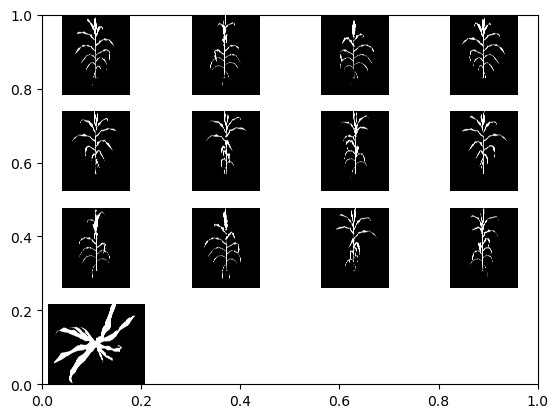

In [5]:

bin_images = phm_data.bin_images(data_dir)
calibrations = phm_data.calibrations(data_dir)

phm_display.show_images(
    list(bin_images["side"].values()) + list(bin_images["top"].values())
)

## 2. Multi-view reconstruction

### 2.1 Associate images and projection function

In [6]:
def routine_select_ref_angle(bin_side_images):
    max_len = 0
    max_angle = None

    for angle in bin_side_images:
        x_pos, y_pos, x_len, y_len = cv2.boundingRect(
            cv2.findNonZero(bin_side_images[angle])
        )

        if x_len > max_len:
            max_len = x_len
            max_angle = angle

    return max_angle

In [7]:
refs_angle_list = [routine_select_ref_angle(bin_images["side"])]
print(refs_angle_list)

image_views = list()
for id_camera in bin_images:
    for angle in bin_images[id_camera]:
        projection = calibrations[id_camera].get_projection(angle)

        image_ref = None
        if id_camera == "side" and angle in refs_angle_list:
            image_ref = bin_images[id_camera][angle]

        inclusive = False
        if id_camera == "top":
            inclusive = True

        image_views.append(
            phm_obj.ImageView(
                bin_images[id_camera][angle],
                projection,
                inclusive=inclusive,
                image_ref=image_ref,
            )
        )

[30]


### 2.2 Do multi-view reconstruction

In [8]:
voxels_size = 16  # mm
error_tolerance = 0
voxel_grid = phm_mvr.reconstruction_3d(
    image_views, voxels_size=voxels_size, error_tolerance=error_tolerance
)

### 2.4 Save / Load voxel grid

In [9]:
voxel_grid.write(f"plant_{plant_number}_size_{voxels_size}.npz")

In [10]:
voxel_grid = phm_obj.VoxelGrid.read(f"plant_{plant_number}_size_{voxels_size}.npz")

### 2.5 Viewing

In [11]:
phm_display_notebook.show_voxel_grid(voxel_grid, size=1)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

## 3.Meshing

In [12]:
vertices, faces = phm_mesh.meshing(
    voxel_grid.to_image_3d(), reduction=0.90, smoothing_iteration=5, verbose=True
)

print("Number of vertices : {nb_vertices}".format(nb_vertices=len(vertices)))
print("Number of faces : {nb_faces}".format(nb_faces=len(faces)))

Marching cubes : 
	Iso value :0.5

	There are 10104 points.
	There are 20070 polygons.
Smoothing : 
	Feature angle :120.0
	Number of iteration :5
	Pass band : 0.01

Decimation : 
	Reduction (percentage) :0.9

	Before decimation
	-----------------
	There are 10104 points.
	There are 20070 polygons.

	After decimation
	-----------------
	There are 0.9 points.
	There are 10104 polygons.
Number of vertices : 1019
Number of faces : 2006


### Viewing

In [13]:
phm_display_notebook.show_mesh(vertices, faces)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…